# MLIKH Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **MLIKH (Multi-Lambda IKH)** model to steady-state flow curve data
2. Understand **multi-mode thixotropy** with distributed timescales
3. Compare **per_mode** vs **weighted_sum** yield formulations
4. Analyze how multiple modes capture complex flow behavior
5. Calibrate parameters for downstream synthetic data generation

## Prerequisites

- NB01-06: MIKH tutorials (single-mode understanding)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-4 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ml_ikh_flow_curve,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mlikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


81

## 2. Theory: Multi-Mode IKH

The **MLIKH (Multi-Lambda IKH)** model extends MIKH to N modes connected in parallel, capturing **distributed thixotropic timescales**.

### Motivation

Real materials often exhibit:
- Multiple restructuring timescales
- Broad relaxation spectra
- Complex flow history dependence

### Two Yield Formulations

**1. Per-Mode Yield** (default):
- Each mode has independent yield surface
- Total stress = $\sum_i \sigma_i$ (parallel connection)
- Parameters: 7 per mode + 1 global

**2. Weighted-Sum Yield**:
- Single global yield surface: $\sigma_y = \sigma_{y0} + k_3 \sum_i w_i \lambda_i$
- All modes share elastic/plastic response
- Parameters: 5 global + 3 per mode

### Per-Mode Parameters (for each mode $i$)

| Parameter | Symbol | Description |
|-----------|--------|-------------|
| `G_i` | $G_i$ | Mode shear modulus (Pa) |
| `C_i` | $C_i$ | Kinematic hardening modulus (Pa) |
| `gamma_dyn_i` | $\gamma_{dyn,i}$ | Dynamic recovery |
| `sigma_y0_i` | $\sigma_{y0,i}$ | Minimal yield stress (Pa) |
| `delta_sigma_y_i` | $\Delta\sigma_{y,i}$ | Structural yield contribution (Pa) |
| `tau_thix_i` | $\tau_{thix,i}$ | Thixotropic timescale (s) |
| `Gamma_i` | $\Gamma_i$ | Breakdown coefficient |

### Key Physics

- **Distributed timescales**: Different modes restructure at different rates
- **Parallel stress**: Total stress is sum of mode contributions
- **Independent yielding**: Each mode can yield independently (per_mode)

## 3. Load Data

In [3]:
# Load flow curve data (same as MIKH NB01)
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


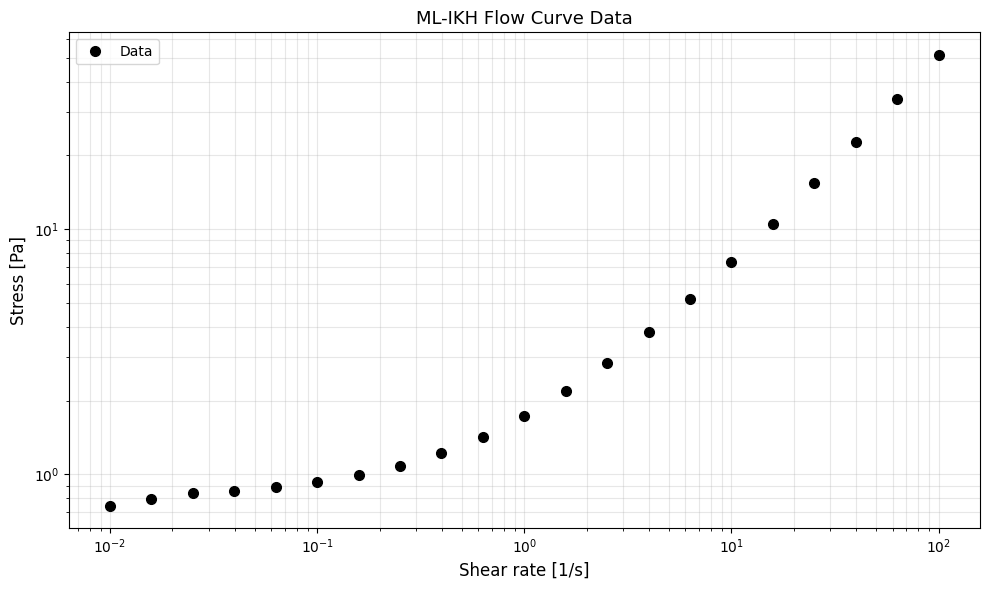

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Flow Curve Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Per-Mode Yield (2 modes)

In [5]:
# Create MLIKH model with 2 modes, per_mode yield
n_modes = 2
model_per_mode = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names_pm = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

print(f"MLIKH (per_mode, {n_modes} modes): {len(param_names_pm)} parameters")
print(f"Parameters: {param_names_pm}")

MLIKH (per_mode, 2 modes): 15 parameters
Parameters: ['G_1', 'C_1', 'gamma_dyn_1', 'sigma_y0_1', 'delta_sigma_y_1', 'tau_thix_1', 'Gamma_1', 'G_2', 'C_2', 'gamma_dyn_2', 'sigma_y0_2', 'delta_sigma_y_2', 'tau_thix_2', 'Gamma_2', 'eta_inf']


In [6]:
# Fit model
t0 = time.time()
model_per_mode.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters (per-mode):")
for name in param_names_pm:
    val = model_per_mode.parameters.get_value(name)
    print(f"  {name:18s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.690577s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=4.1340 | elapsed=1.691s | final_gradient_norm=1.0150e-06


NLSQ fit time: 1.95 s

Fitted parameters (per-mode):
  G_1                = 500
  C_1                = 3822
  gamma_dyn_1        = 4323
  sigma_y0_1         = 0.6641
  delta_sigma_y_1    = 1.108e-05
  tau_thix_1         = 1.269e+09
  Gamma_1            = 9954
  G_2                = 500.3
  C_2                = 250
  gamma_dyn_2        = 1.013
  sigma_y0_2         = 0.6641
  delta_sigma_y_2    = 3.188e-05
  tau_thix_2         = 2.547e+09
  Gamma_2            = 9941
  eta_inf            = 0.513


In [7]:
# Compute fit quality
stress_pred_pm = model_per_mode.predict(gamma_dot, test_mode="flow_curve")
metrics_pm = compute_fit_quality(stress, stress_pred_pm)

print(f"\nFit Quality (per_mode):")
print(f"  R^2:   {metrics_pm['R2']:.6f}")
print(f"  RMSE:  {metrics_pm['RMSE']:.4g} Pa")


Fit Quality (per_mode):
  R^2:   0.997611
  RMSE:  0.6275 Pa


### 4.2 Weighted-Sum Yield (2 modes)

In [8]:
# Create MLIKH model with weighted_sum yield
model_weighted_sum = MLIKH(n_modes=n_modes, yield_mode="weighted_sum")
param_names_ws = get_mlikh_param_names(n_modes=n_modes, yield_mode="weighted_sum")

print(f"MLIKH (weighted_sum, {n_modes} modes): {len(param_names_ws)} parameters")
print(f"Parameters: {param_names_ws}")

MLIKH (weighted_sum, 2 modes): 11 parameters
Parameters: ['G', 'C', 'gamma_dyn', 'sigma_y0', 'k3', 'tau_thix_1', 'Gamma_1', 'w_1', 'tau_thix_2', 'Gamma_2', 'w_2']


In [9]:
# Fit model
t0 = time.time()
model_weighted_sum.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq_ws = time.time() - t0

print(f"NLSQ fit time: {t_nlsq_ws:.2f} s")

# Compute fit quality
stress_pred_ws = model_weighted_sum.predict(gamma_dot, test_mode="flow_curve")
metrics_ws = compute_fit_quality(stress, stress_pred_ws)

print(f"\nFit Quality (weighted_sum):")
print(f"  R^2:   {metrics_ws['R2']:.6f}")
print(f"  RMSE:  {metrics_ws['RMSE']:.4g} Pa")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.296754s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.1340 | elapsed=1.297s | final_gradient_norm=0.0019


NLSQ fit time: 1.58 s

Fit Quality (weighted_sum):
  R^2:   0.997611
  RMSE:  0.6275 Pa


### 4.3 Compare Yield Formulations

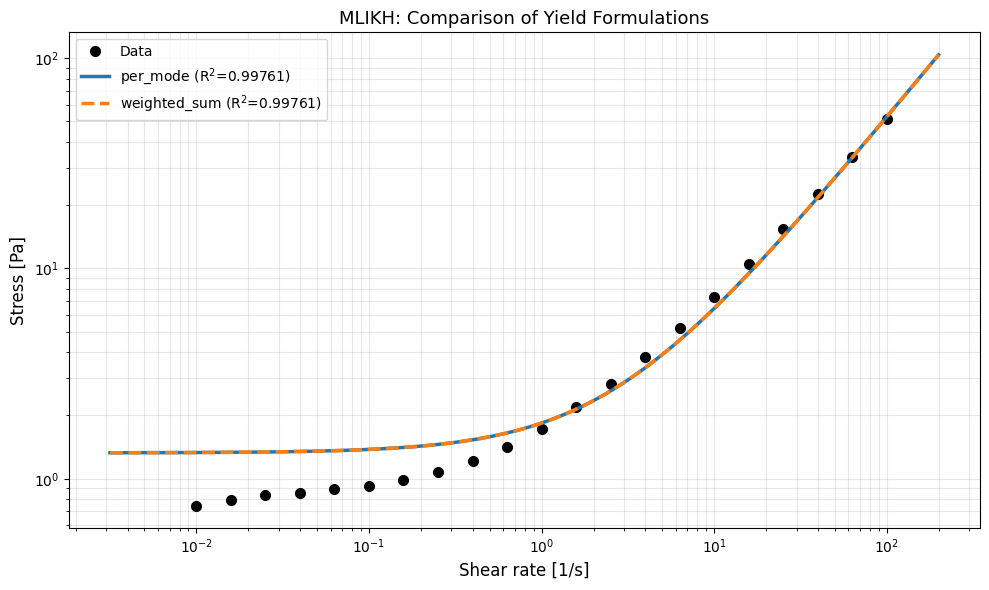

In [10]:
# Plot comparison
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pm_fine = model_per_mode.predict(gamma_dot_fine, test_mode="flow_curve")
stress_ws_fine = model_weighted_sum.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.loglog(gamma_dot_fine, stress_pm_fine, "-", lw=2.5, color="C0", 
          label=f"per_mode (R$^2$={metrics_pm['R2']:.5f})")
ax.loglog(gamma_dot_fine, stress_ws_fine, "--", lw=2.5, color="C1", 
          label=f"weighted_sum (R$^2$={metrics_ws['R2']:.5f})")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("MLIKH: Comparison of Yield Formulations", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.4 Mode Contribution Analysis

In [11]:
# Analyze per-mode contributions (for per_mode model)
print("Mode Contributions (per_mode formulation):")
print("=" * 50)

for i in range(1, n_modes + 1):
    G_i = model_per_mode.parameters.get_value(f"G_{i}")
    sigma_y0_i = model_per_mode.parameters.get_value(f"sigma_y0_{i}")
    delta_sigma_y_i = model_per_mode.parameters.get_value(f"delta_sigma_y_{i}")
    tau_thix_i = model_per_mode.parameters.get_value(f"tau_thix_{i}")
    Gamma_i = model_per_mode.parameters.get_value(f"Gamma_{i}")
    
    print(f"\nMode {i}:")
    print(f"  G_{i} = {G_i:.3g} Pa")
    print(f"  sigma_y0_{i} = {sigma_y0_i:.3g} Pa")
    print(f"  delta_sigma_y_{i} = {delta_sigma_y_i:.3g} Pa")
    print(f"  tau_thix_{i} = {tau_thix_i:.3g} s")
    print(f"  Gamma_{i} = {Gamma_i:.4g}")

Mode Contributions (per_mode formulation):

Mode 1:
  G_1 = 500 Pa
  sigma_y0_1 = 0.664 Pa
  delta_sigma_y_1 = 1.11e-05 Pa
  tau_thix_1 = 1.27e+09 s
  Gamma_1 = 9954

Mode 2:
  G_2 = 500 Pa
  sigma_y0_2 = 0.664 Pa
  delta_sigma_y_2 = 3.19e-05 Pa
  tau_thix_2 = 2.55e+09 s
  Gamma_2 = 9941


## 5. Bayesian Inference with NUTS

In [12]:
# Use per_mode model for Bayesian inference
model = model_per_mode
param_names = param_names_pm

initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}

# Fast demo config
# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:24,  1.77it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  16%|█▌        | 24/150 [00:00<00:02, 47.73it/s, 255 steps of size 2.01e-03. acc. prob=0.78]

sample:  35%|███▍      | 52/150 [00:00<00:00, 99.50it/s, 15 steps of size 1.73e-01. acc. prob=0.82] 

sample: 100%|██████████| 150/150 [00:00<00:00, 178.48it/s, 31 steps of size 1.73e-01. acc. prob=0.89]


Bayesian inference time: 3.1 s


In [13]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    0.9901       140      PASS
            C_1    0.9905       114      PASS
    gamma_dyn_1    1.0300        39     CHECK
     sigma_y0_1    1.0638        39     CHECK
delta_sigma_y_1    0.9947        86     CHECK
     tau_thix_1    0.9921        97     CHECK
        Gamma_1    0.9952        81     CHECK
            G_2    1.0033       137      PASS
            C_2    0.9984       183      PASS
    gamma_dyn_2    0.9930       107      PASS
     sigma_y0_2    1.0863        38     CHECK
delta_sigma_y_2    1.0329        64     CHECK
     tau_thix_2    1.0052        79     CHECK
        Gamma_2    0.9922       110      PASS
        eta_inf    1.0176        84     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


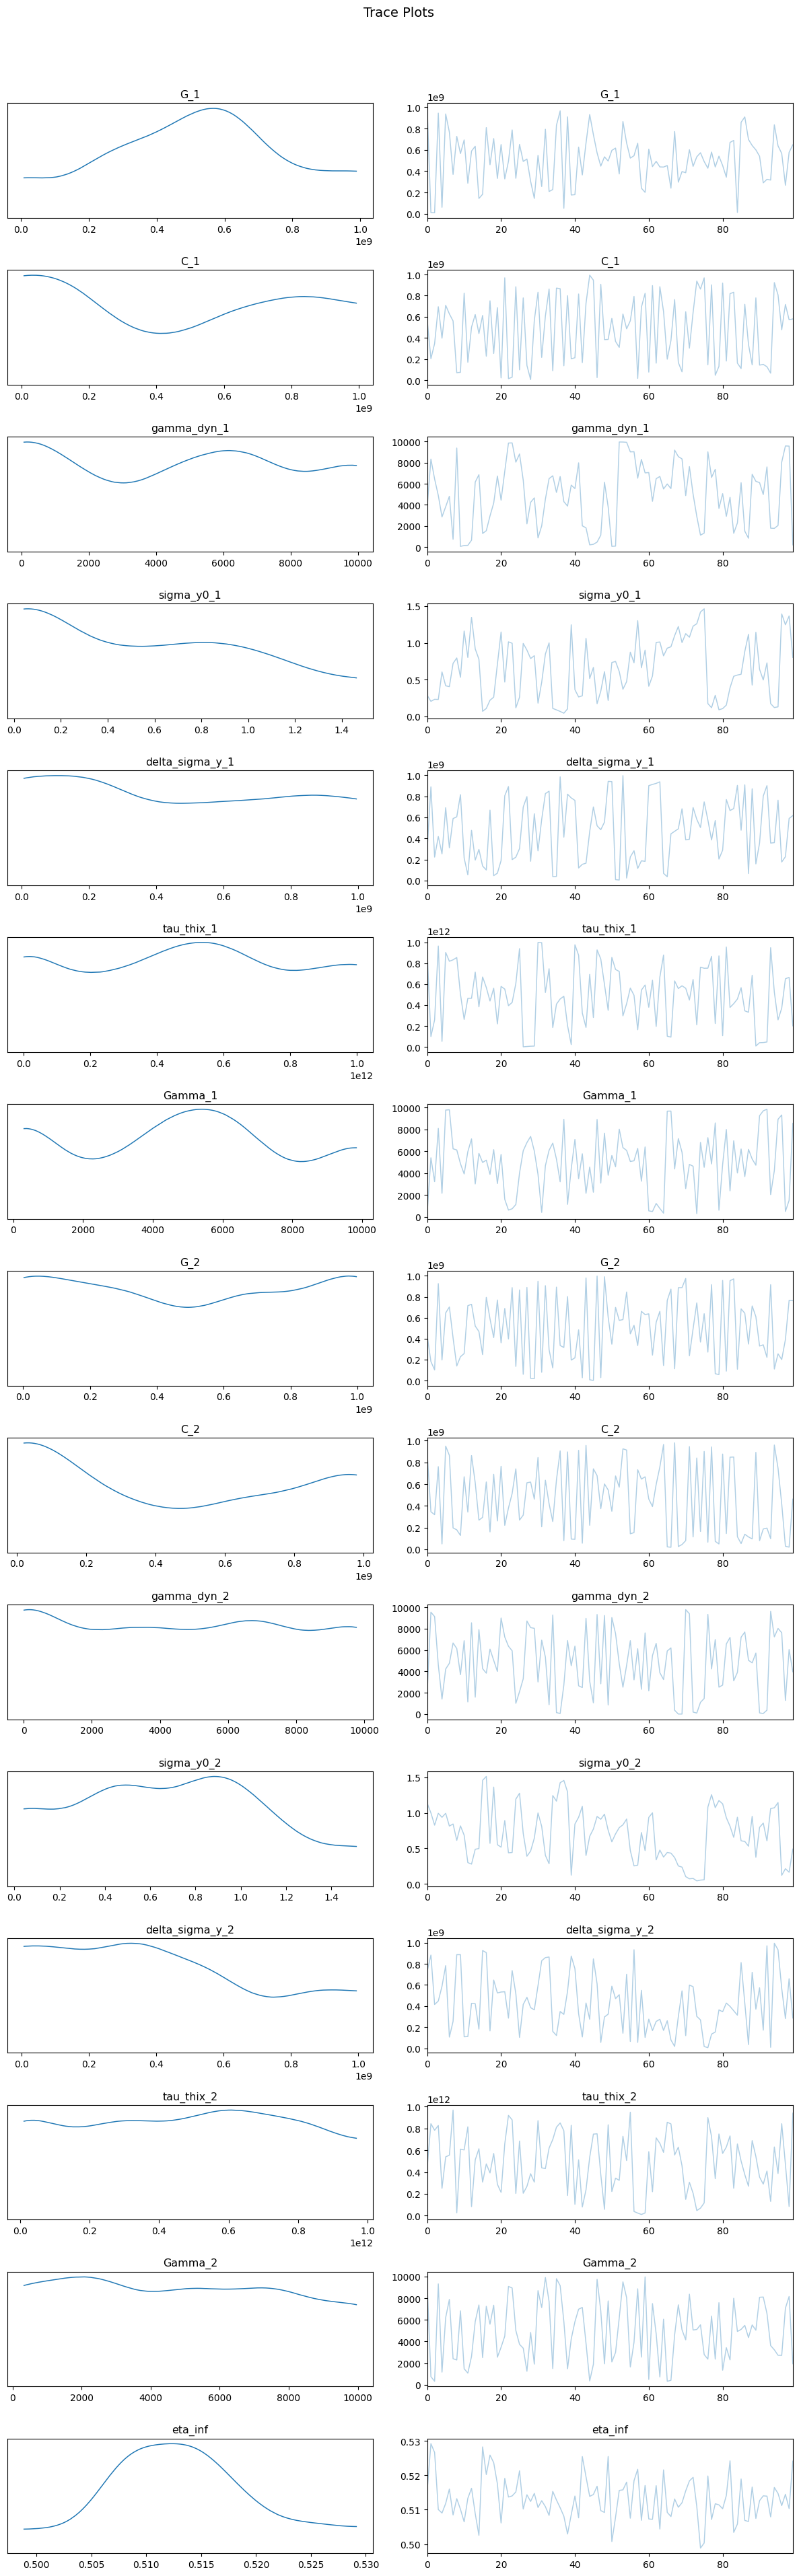

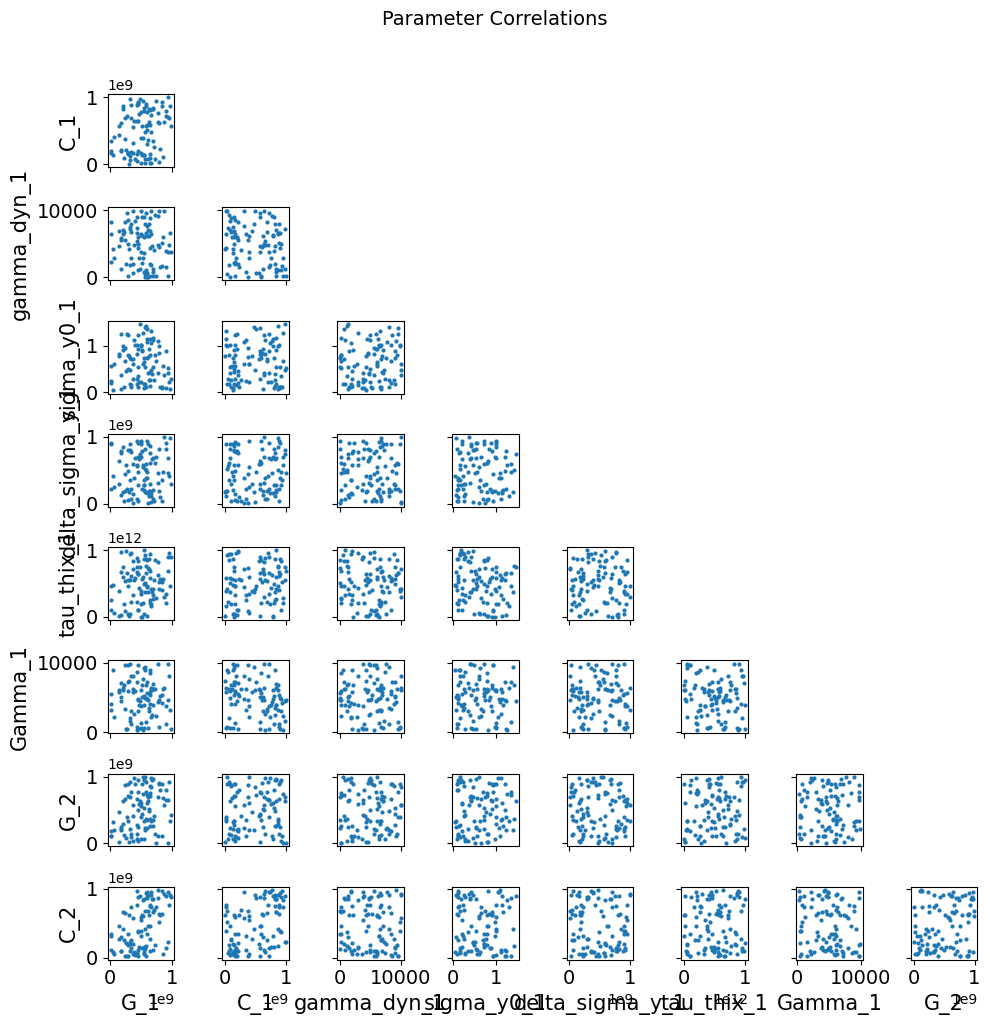

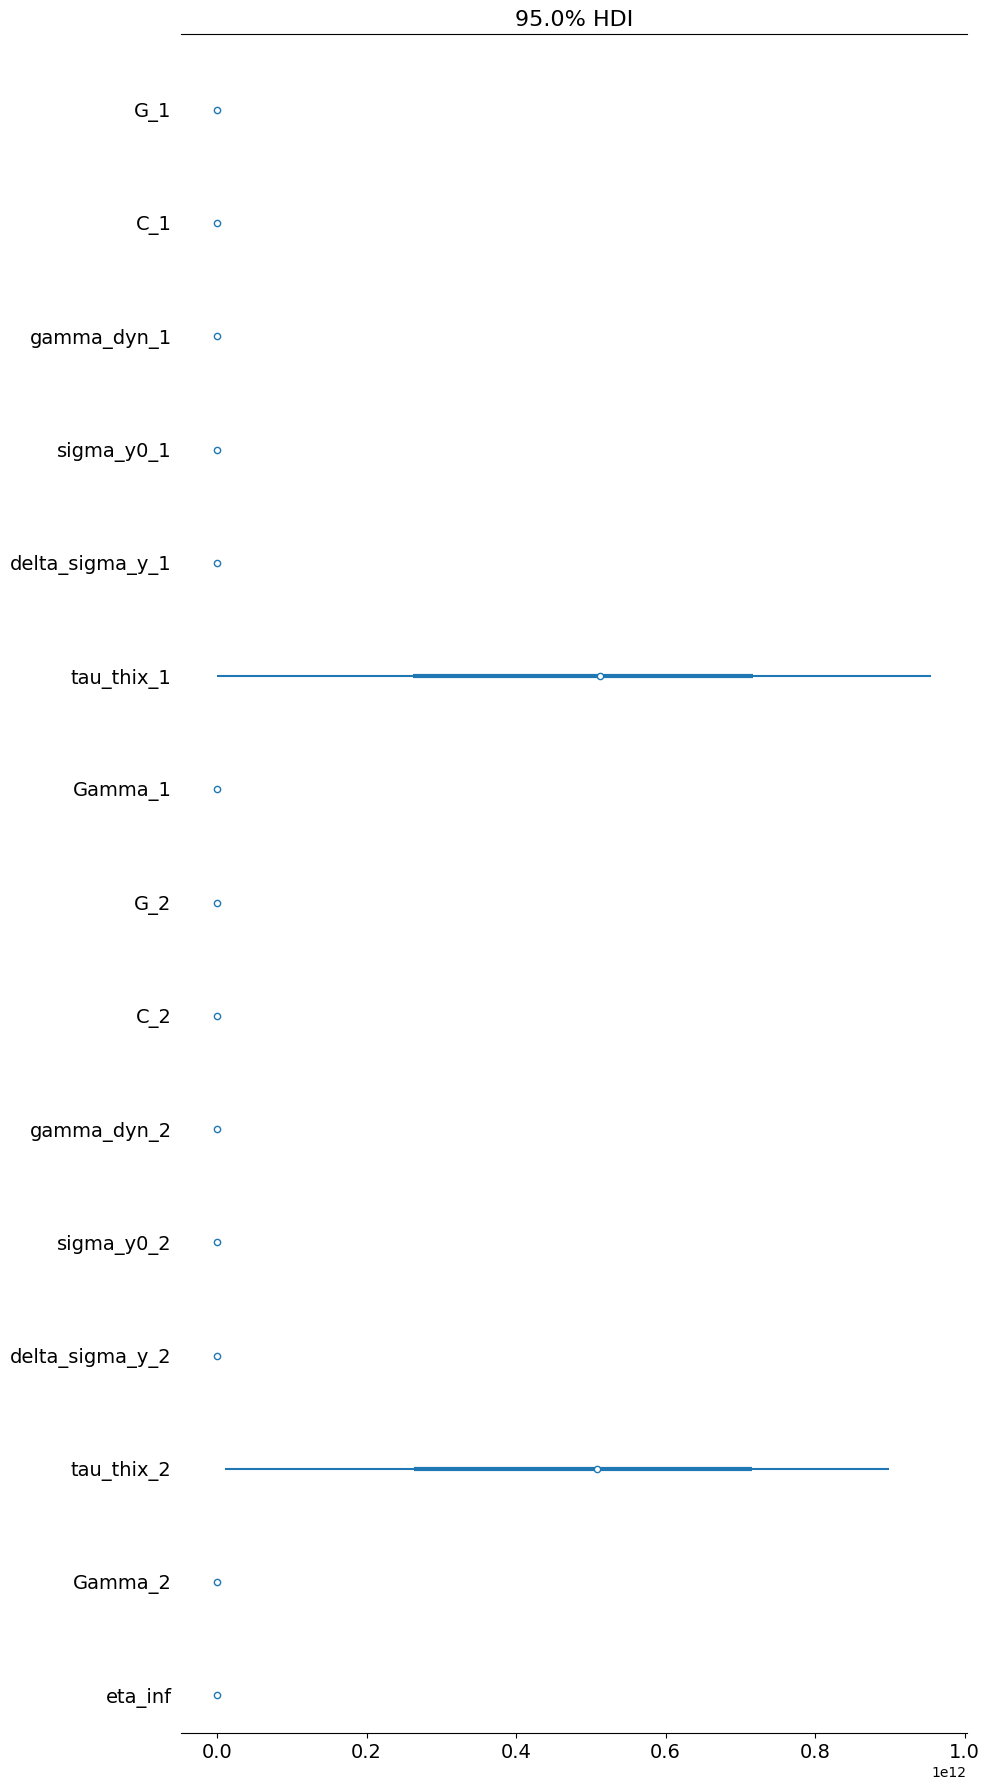

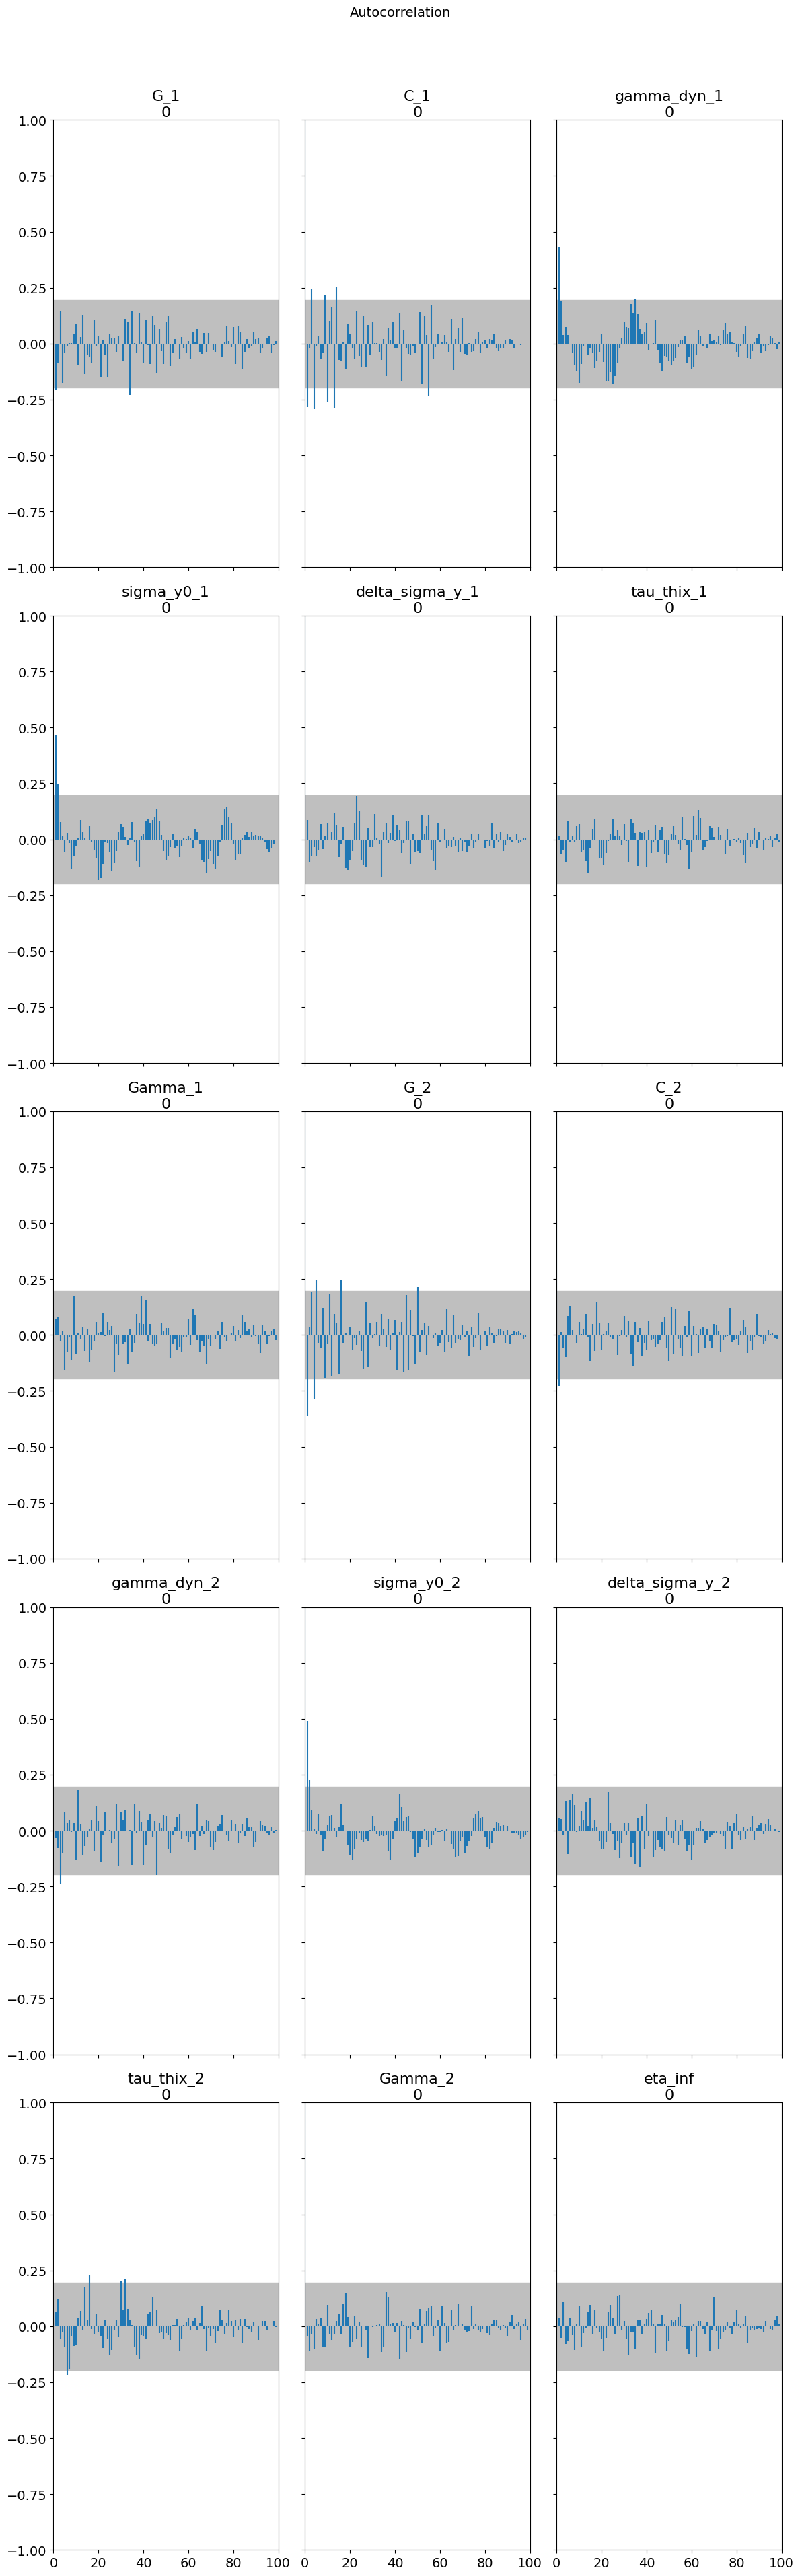

In [14]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

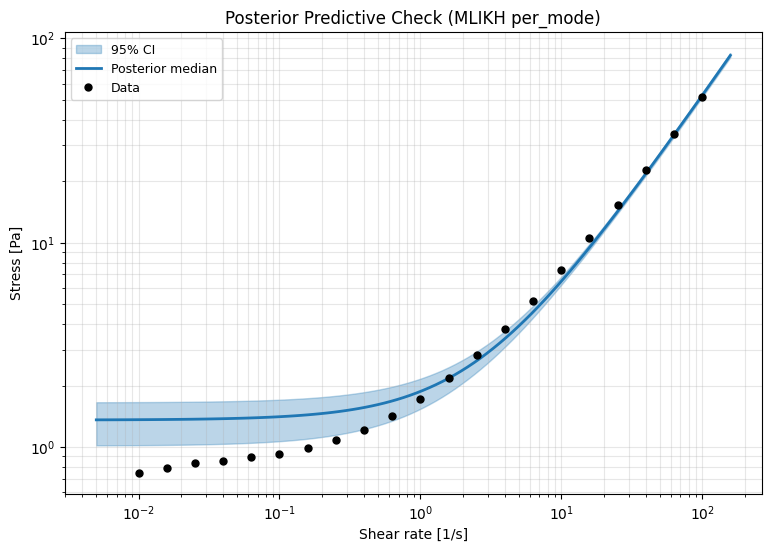

In [15]:
# Posterior predictive with 95% credible intervals
fig, ax = plot_posterior_predictive(
    gamma_dot, stress, model, result,
    test_mode="flow_curve", param_names=param_names,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    log_scale=True, title="Posterior Predictive Check (MLIKH per_mode)",
)
display(fig)
plt.close(fig)

## 6. Physical Interpretation

### Multi-Mode Benefits

1. **Distributed timescales**: Modes with different $\tau_{thix,i}$ capture multiple restructuring rates
2. **Flexible yield**: Per-mode allows different yield stresses for different structural components
3. **Complex flow curves**: Captures inflections and subtle curvature in data

### Mode Identification

- **Fast mode** (small $\tau_{thix}$): Responds quickly, dominates high-rate behavior
- **Slow mode** (large $\tau_{thix}$): Responds slowly, dominates low-rate behavior

### Per-Mode vs Weighted-Sum

- **Per-mode**: More flexible, each mode contributes independently
- **Weighted-sum**: More constrained, single yield surface with structure contribution

## 7. Save Results

In [16]:
# Save results for downstream notebooks
save_ikh_results(model, result, "mlikh", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB09: Stress Relaxation")
print("  - NB11: SAOS")

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/flow_curve/
  nlsq_params_flow_curve.json: 15 parameters
  posterior_flow_curve.json: 100 draws

Parameters saved for synthetic data generation in:
  - NB09: Stress Relaxation
  - NB11: SAOS


## Key Takeaways

1. **MLIKH extends MIKH** to N modes with distributed thixotropic timescales

2. **Two yield formulations**:
   - **per_mode**: Independent yield surfaces, more flexible
   - **weighted_sum**: Single global yield, more constrained

3. **Parameter count**: 7N + 1 (per_mode) vs 5 + 3N (weighted_sum)

4. **Mode identification**: Different modes capture fast vs slow restructuring

5. **Multi-mode benefit**: Captures complex flow behavior that single-mode cannot

6. **Bayesian inference**: More challenging with more parameters, but NLSQ warm-start helps

### Next Steps

- **NB08**: MLIKH Startup (richer overshoot dynamics)
- **NB09**: MLIKH Relaxation (multi-mode decay)
- **NB10**: MLIKH Creep
- **NB11**: MLIKH SAOS (broadened spectra)
- **NB12**: MLIKH LAOS

In [17]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
